# Telco Customer Churn
### Final Project Fusesmachines
<p>Presented by Mario Toribio</p>
<p>04/04/2024</p>
<p>Based on the dataset <a href="https://www.kaggle.com/datasets/blastchar/telco-customer-churn">Telco Customer Churn</a> from Kaggle</p>
<hr>

### Problem statement: 
The churn is a problem that affects every company. According to research done by Database Marketing Institute, the average churn rate in the telecom industry is approximately 1.9% per month across the four major carriers, but could rise as high as 67% annually for prepaid services. Since the cost of acquiring new customers is up to 25 times higher than the cost of retaining them, fostering customer loyalty is key.

### Preprocessing

Loading libraries and preprocess functions

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.feature_selection import mutual_info_regression

%matplotlib inline

sns.set_theme(style="whitegrid", palette="muted", context="talk", font_scale=1.2)

plt.rcParams.update(
    {
        "figure.figsize": (10, 6),
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 12,
    }
)

import warnings

warnings.filterwarnings("ignore")


def reduce_mem_usage(df, verbose=True):
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df


## EDA


def print_missing_table(train_copy, test_copy, target):
    table = PrettyTable()
    table.field_names = ["Feature", "Data Type", "Train Missing %", "Test Missing %"]

    for column in train_copy.columns:
        data_type = str(train_copy[column].dtype)
        non_null_count_train = np.round(
            100 - train_copy[column].count() / train_copy.shape[0] * 100, 1
        )
        non_null_count_test = (
            np.round(100 - test_copy[column].count() / test_copy.shape[0] * 100, 1)
            if column != target
            else "NA"
        )
        table.add_row([column, data_type, non_null_count_train, non_null_count_test])

    print(table)


def plot_categorical(data, column_name):
    f, ax = plt.subplots(1, 2, figsize=(18, 8))
    data[column_name].value_counts().plot.pie(
        explode=[0, 0.1], autopct="%1.1f%%", ax=ax[0], shadow=True
    )
    ax[0].set_title(column_name)
    ax[0].set_ylabel("")
    sns.countplot(x=column_name, data=data, ax=ax[1])
    ax[1].set_title(column_name)
    plt.show()


def plot_correlation_heatmap(data, numerical_cols, target_col):
    df = data = data[numerical_cols + [target_col]]
    corr = df.corr()
    mask = np.triu(corr)
    plt.figure(figsize=(15, 11))
    sns.heatmap(corr, mask=mask, annot=True, fmt=".4f")
    plt.show()


def plot_pairplot(data, numerical_cols, target_col):
    pairplot = sns.pairplot(
        data=data[numerical_cols + [target_col]],
        hue=target_col,
        corner=True,
        plot_kws={"alpha": 0.7, "s": 50, "edgecolor": "k"},
        palette="Set1",
        diag_kws={"edgecolor": "k"},
    )
    pairplot.fig.suptitle("Pairplot of Numerical Variables", y=1.02)
    plt.show()


def plot_violin_plots(data, numerical_cols, target):
    n_rows = len(numerical_cols)
    fig, axs = plt.subplots(n_rows, 1, figsize=(12, 4 * n_rows))

    for i, col in enumerate(numerical_cols):
        sns.violinplot(x=target, y=col, data=data, ax=axs[i])
        axs[i].set_title(f"{col.title()} Distribution by Target (Train)", fontsize=14)
        axs[i].set_xlabel(target.title(), fontsize=12)
        axs[i].set_ylabel(col.title(), fontsize=12)
        sns.despine()

    fig.tight_layout()
    plt.show()


def plot_histograms(data, continuous_vars, target_col):
    for column in continuous_vars:
        if data[column].dtype == "float16":
            data[column] = data[column].astype("float32")

        fig, ax = plt.subplots(figsize=(18, 4))
        sns.histplot(data=data, x=column, hue=target_col, bins=50, kde=True)
        plt.show()


def plot_countplot(data, column_name):
    sns.countplot(x=column_name, data=data)
    plt.title(f"Count Plot of {column_name}")
    plt.show()


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(
        X, y, discrete_features=discrete_features, random_state=0
    )
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [32]:
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.to_pickle("../data/df.pkl")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
target_col = "Churn"
print_missing_table(df, df, target_col)
## We don't have missing values

+------------------+-----------+-----------------+----------------+
|     Feature      | Data Type | Train Missing % | Test Missing % |
+------------------+-----------+-----------------+----------------+
|    customerID    |   object  |       0.0       |      0.0       |
|      gender      |   object  |       0.0       |      0.0       |
|  SeniorCitizen   |   int64   |       0.0       |      0.0       |
|     Partner      |   object  |       0.0       |      0.0       |
|    Dependents    |   object  |       0.0       |      0.0       |
|      tenure      |   int64   |       0.0       |      0.0       |
|   PhoneService   |   object  |       0.0       |      0.0       |
|  MultipleLines   |   object  |       0.0       |      0.0       |
| InternetService  |   object  |       0.0       |      0.0       |
|  OnlineSecurity  |   object  |       0.0       |      0.0       |
|   OnlineBackup   |   object  |       0.0       |      0.0       |
| DeviceProtection |   object  |       0.0      

#### First EDA

In [6]:
# Unique value counts for each column
unique_counts = df.nunique()

# Threshold to distinguish continuous and categorical
threshold = 12

# Select only numeric columns for continuous variables
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

continuous_vars = unique_counts[
    (unique_counts > threshold) & unique_counts.index.isin(numeric_cols)
].index.tolist()
categorical_vars = unique_counts[
    (unique_counts <= threshold) | ~unique_counts.index.isin(numeric_cols)
].index.tolist()

if target_col in categorical_vars:
    categorical_vars.remove(target_col)

print(f"Categorical Variables: {categorical_vars}")
print(f"Continuous/Numerical Variables: {continuous_vars}")

Categorical Variables: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']
Continuous/Numerical Variables: ['tenure', 'MonthlyCharges']


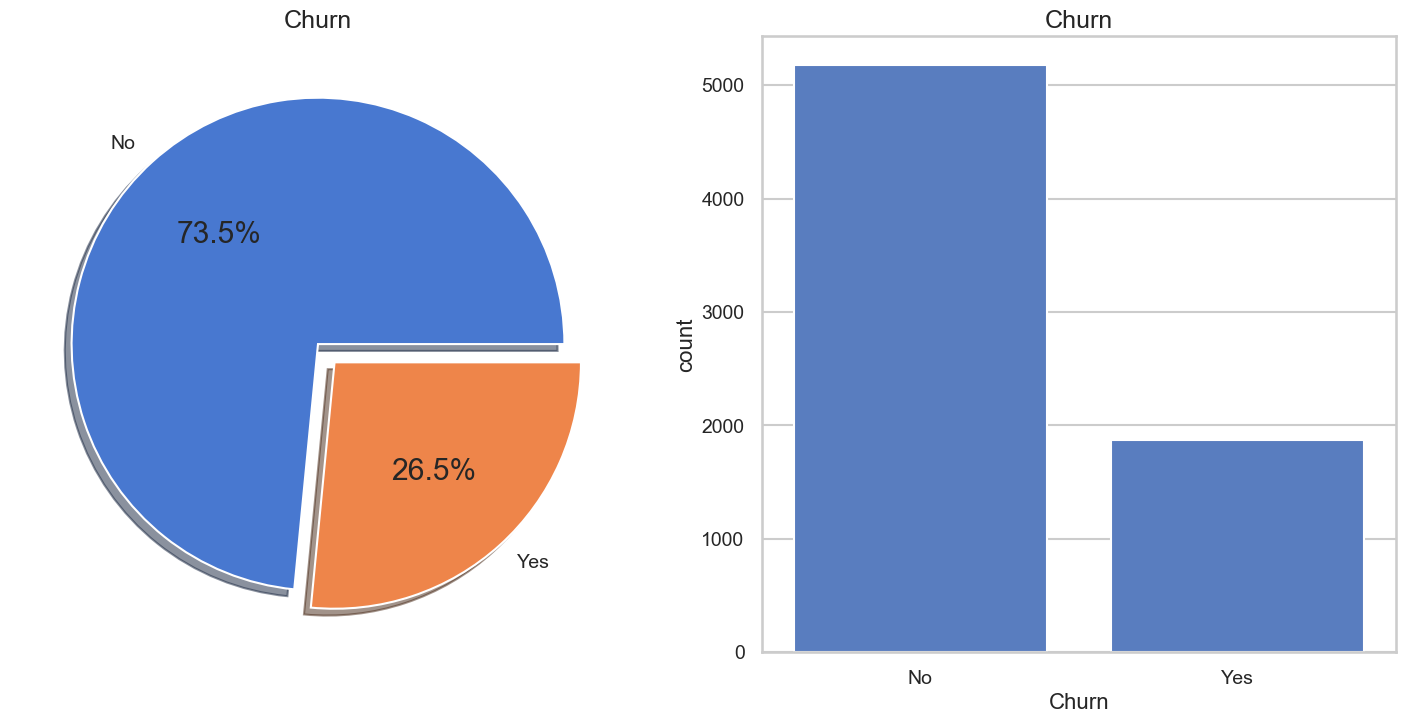

In [7]:
## We don't have imbalaced data. The proportion is great around 25%.
plot_categorical(df, column_name=target_col)

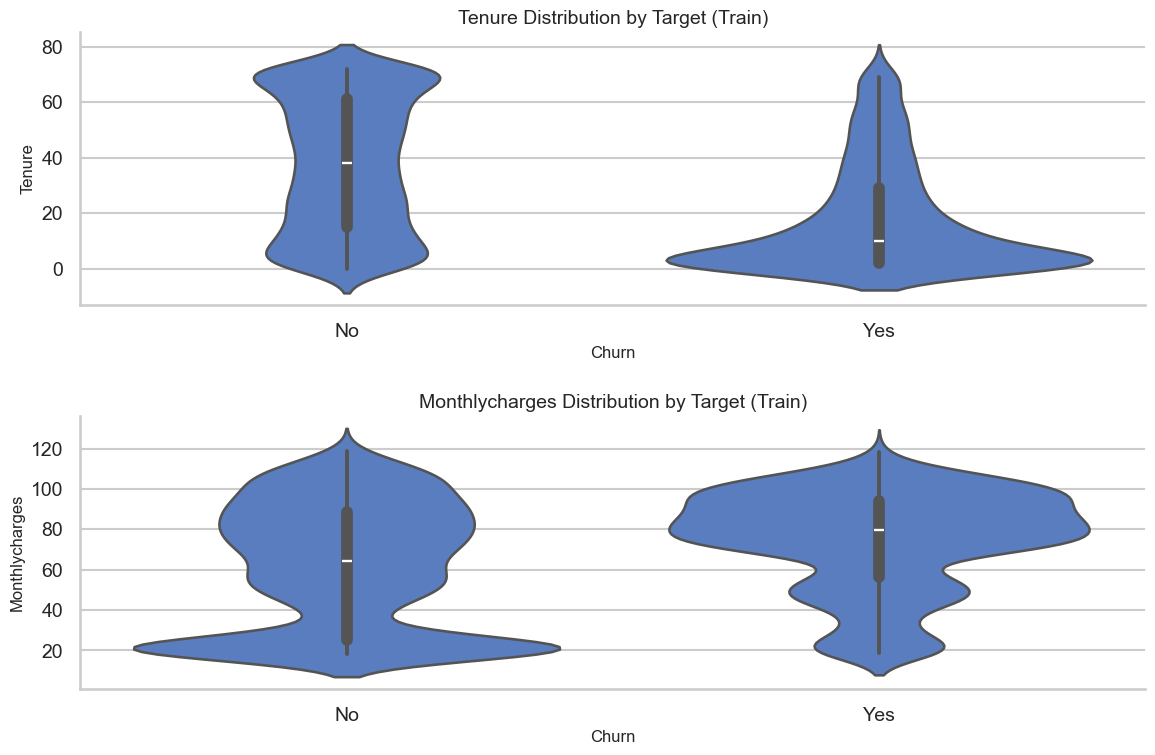

In [8]:
# There is a great difference from the monthlycharges between the churn instead the other. It is good for the model
plot_violin_plots(df, continuous_vars, target_col)

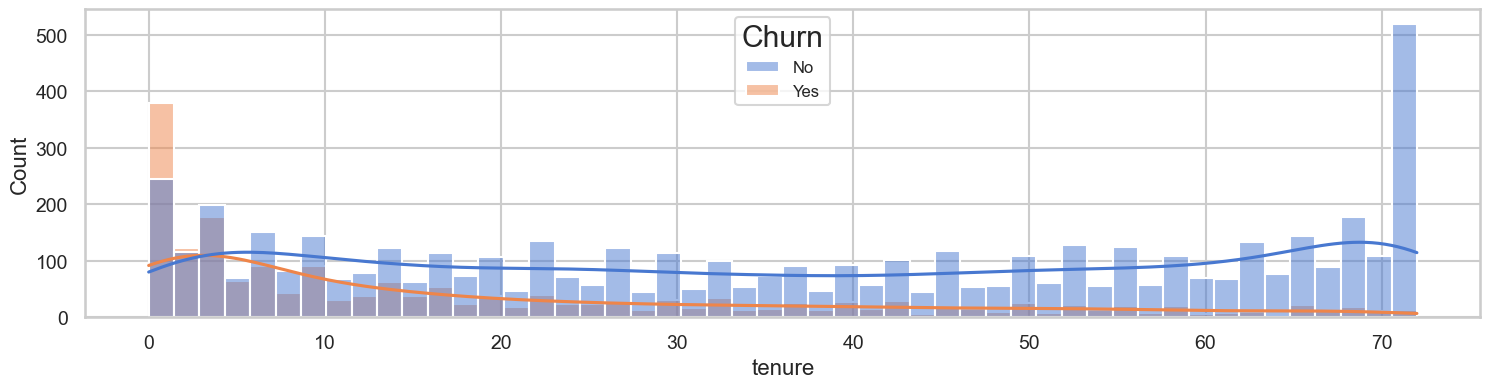

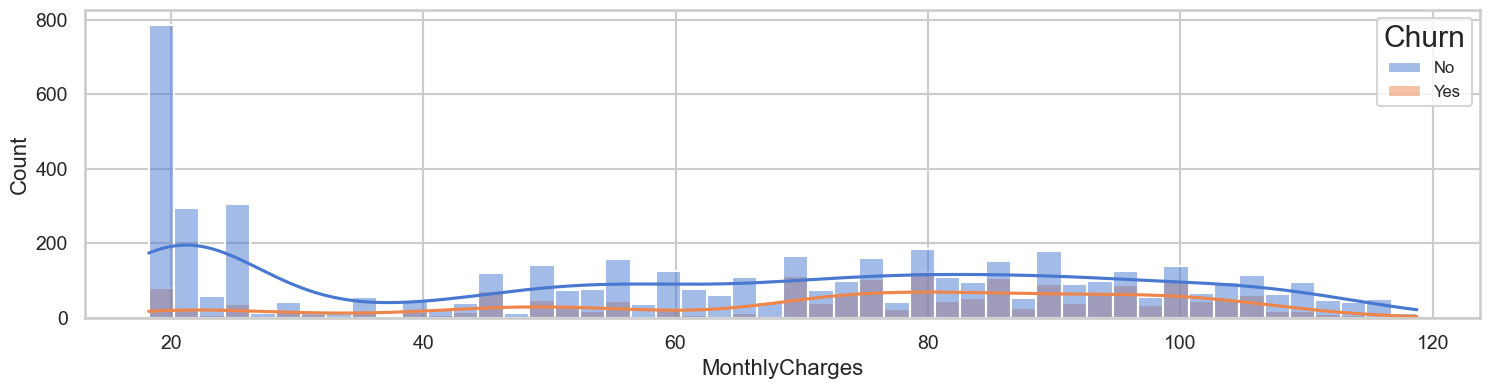

In [9]:
## Distribution is so close to an uniform
plot_histograms(df, continuous_vars, target_col)

### Preprocess

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [11]:
print(f"Objects: {df.dtypes[df.dtypes.values==object].index.to_list()}")
print(f"Float: {df.dtypes[df.dtypes.values=='float64'].index.to_list()}")
print(f"Int: {df.dtypes[df.dtypes.values=='int64'].index.to_list()}")

Objects: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']
Float: ['MonthlyCharges']
Int: ['SeniorCitizen', 'tenure']


#### Feature engineering

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib


class ColumnDropperTransformer:
    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        return X.drop(self.columns, axis=1)

    def fit(self, X, y=None):
        return self


class ConvertDataTransformer:
    def __init__(self) -> None:
        self.objects = [
            "customerID",
            "gender",
            "Partner",
            "Dependents",
            "PhoneService",
            "MultipleLines",
            "InternetService",
            "OnlineSecurity",
            "OnlineBackup",
            "DeviceProtection",
            "TechSupport",
            "StreamingTV",
            "StreamingMovies",
            "Contract",
            "PaperlessBilling",
            "PaymentMethod",
            "Churn",
        ]
        self.floats = ["MonthlyCharges", "TotalCharges"]
        self.ints = ["SeniorCitizen", "tenure"]

    def transform(self, X: pd.DataFrame, y=None):
        X_ = X.copy()
        X_[self.objects] = X_[self.objects].astype(str)
        for col_name in self.floats:
            X_[col_name] = pd.to_numeric(X_[col_name], errors="coerce")
        for col_name in self.ints:
            X_[col_name] = pd.to_numeric(X_[col_name], errors="coerce")
        return X_

    def fit(self, X, y=None):
        return self


class RenameColumns:
    def __init__(self) -> None:
        pass

    def transform(self, X: pd.DataFrame, y=None):
        X_ = X.copy()
        X_.rename(columns={"encode__Churn_Yes": "Churn"}, inplace=True)
        X_.drop("encode__Churn_No", axis=1, inplace=True)
        X_.columns = [
            col_name.replace("encode__", "").replace("remainder__", "")
            for col_name in X_.columns
        ]
        X_.fillna(0, inplace=True)
        return X_

    def fit(self, X, y=None):
        return self


object_columns = [
    "gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
    "Churn",
]
columns_to_drop = ["customerID"]

feature_engineering_pipeline = Pipeline(
    [
        ("change_datatypes", ConvertDataTransformer()),
        ("column_dropper", ColumnDropperTransformer(columns_to_drop)),
        (
            "prep",
            ColumnTransformer(
                [
                    (
                        "encode",
                        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                        object_columns,
                    )
                ],
                remainder="passthrough",
            ).set_output(transform="pandas"),
        ),
        ("rename_columns", RenameColumns()),
    ]
)
feature_engineering_pipeline.fit(df)
joblib.dump(
    feature_engineering_pipeline, "../pipeline/feature_engineering_pipeline.pkl"
)

['../pipeline/feature_engineering_pipeline.pkl']

In [13]:
df_processed = feature_engineering_pipeline.transform(df)

In [14]:
df_processed.head()

,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,...,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0,1,29.85,29.85
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,34,56.95,1889.50
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0,2,53.85,108.15
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,45,42.30,1840.75
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0,2,70.70,151.65


### EDA

In [15]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


#### Univariate Analysis

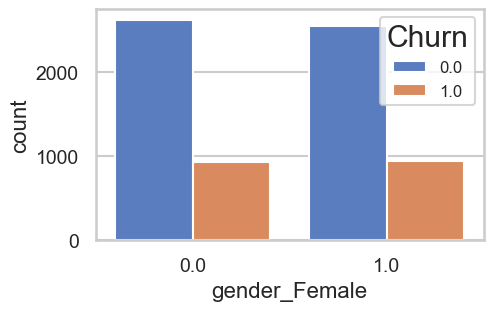

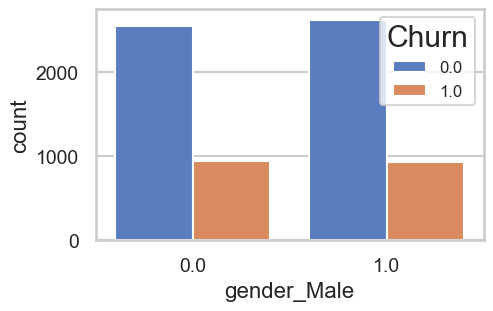

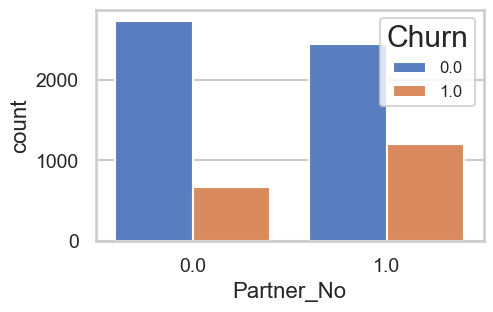

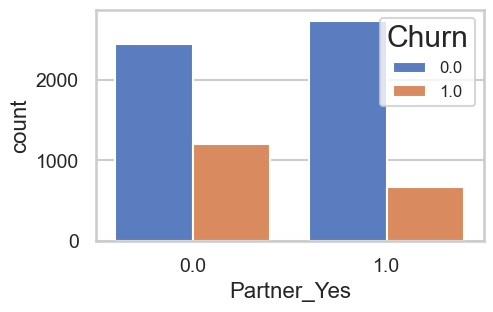

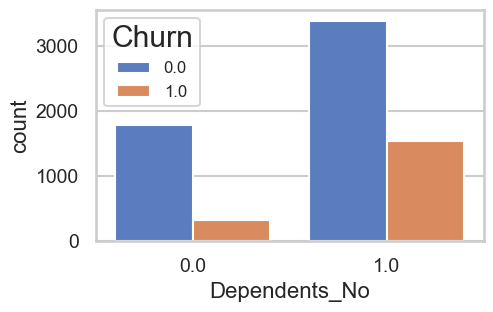

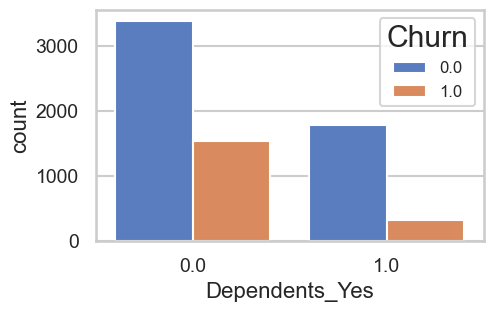

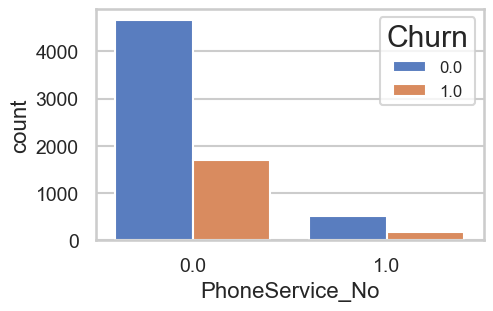

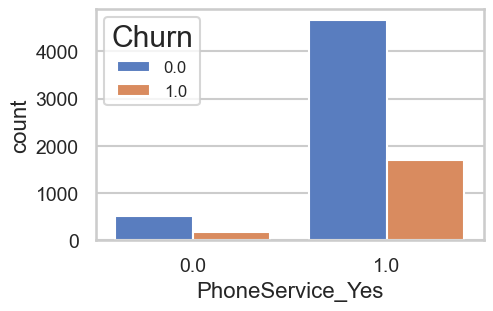

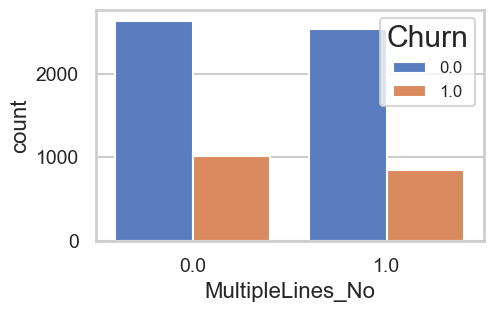

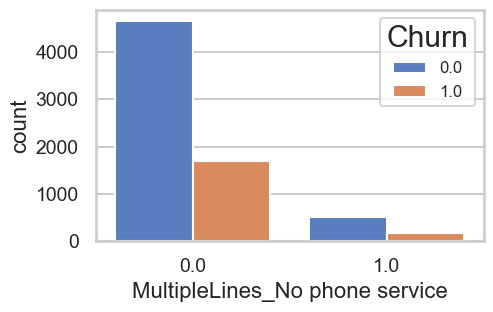

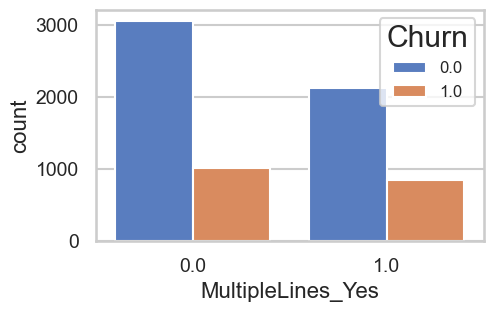

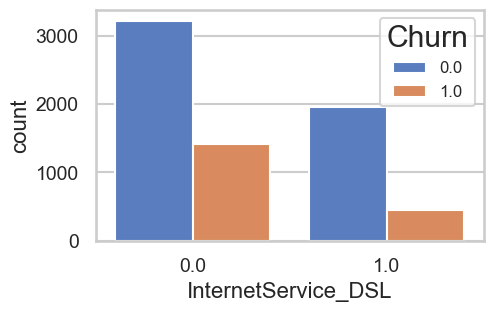

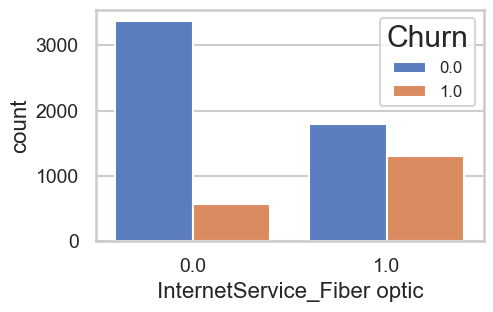

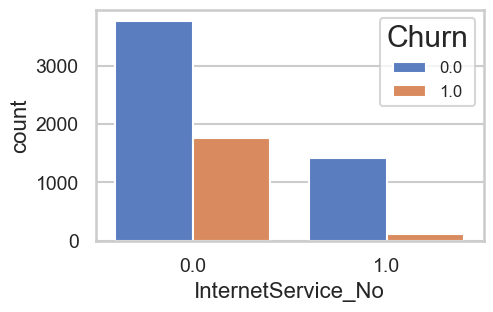

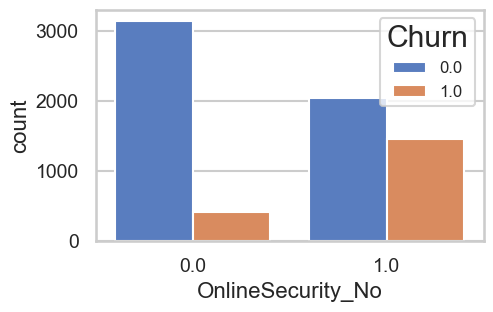

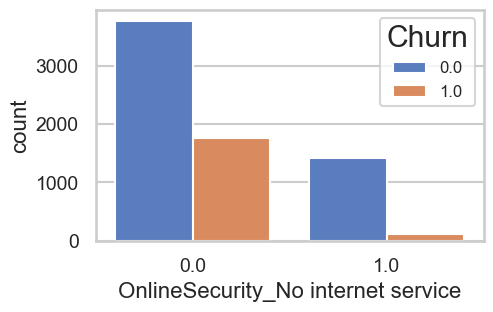

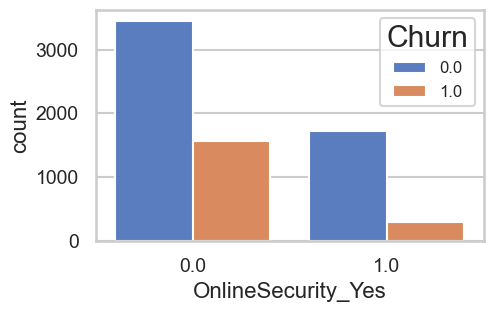

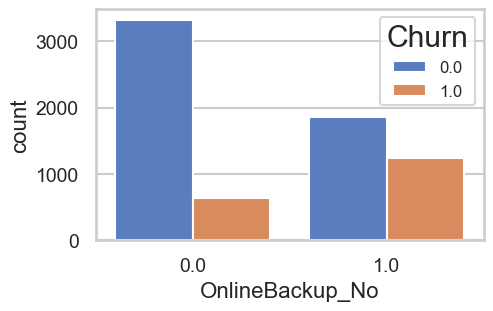

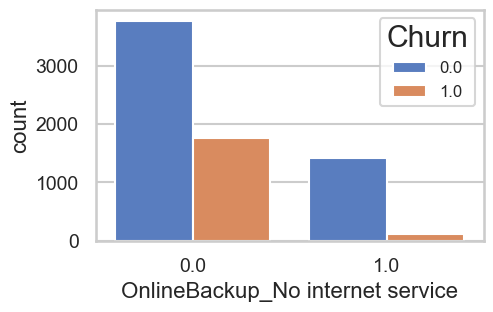

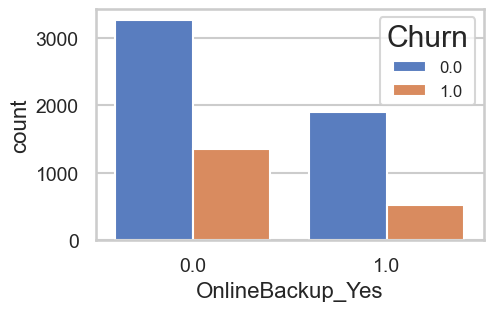

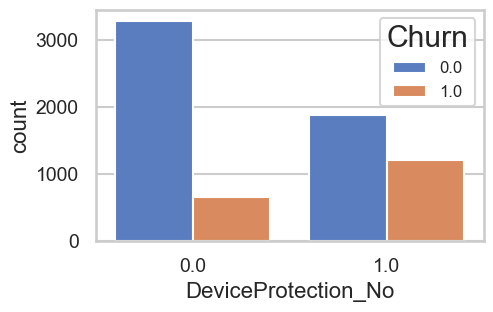

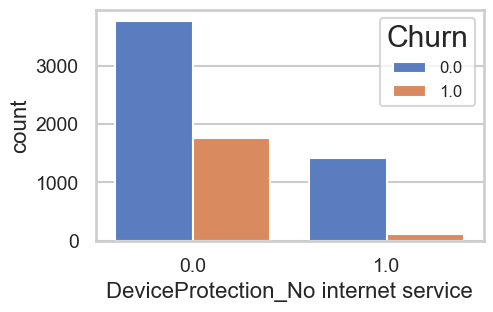

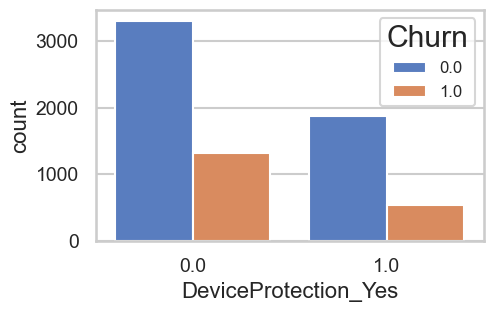

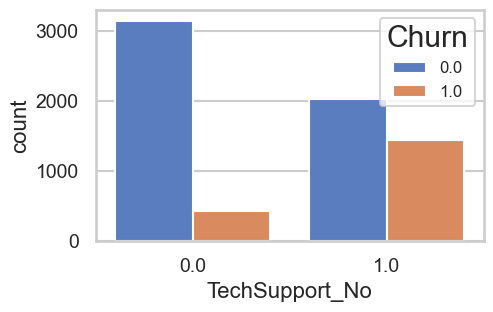

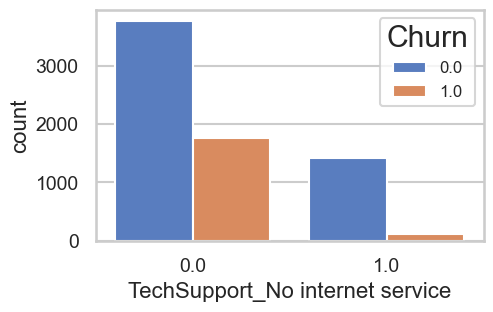

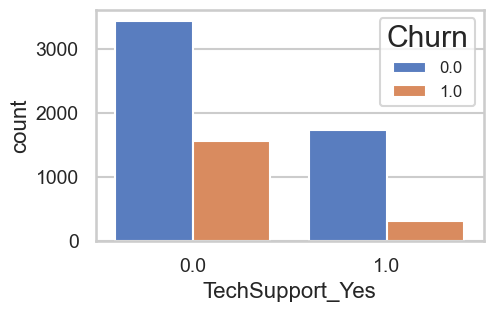

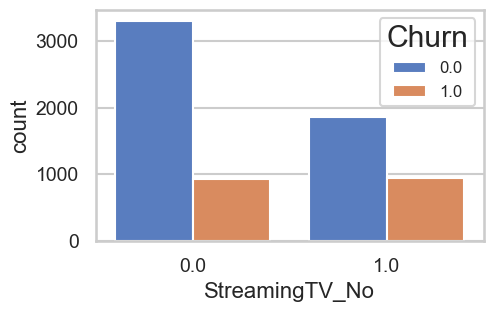

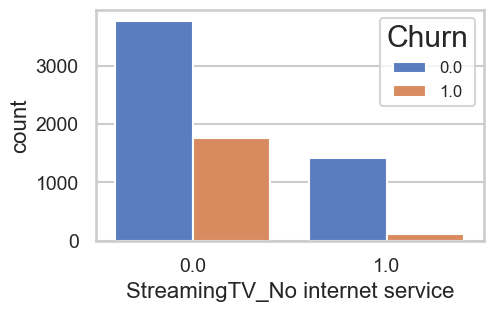

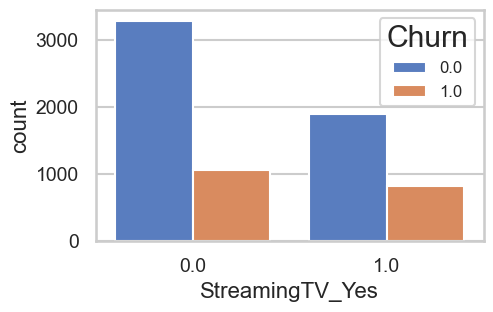

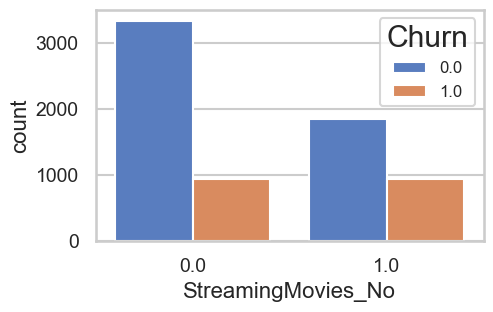

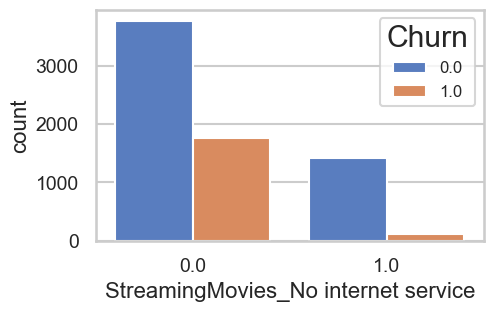

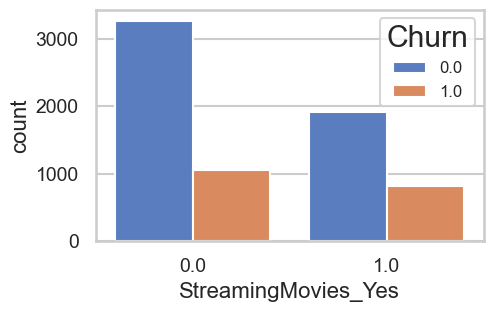

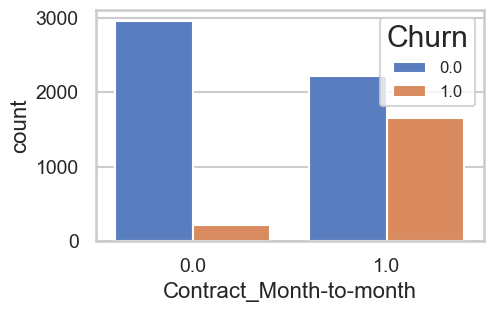

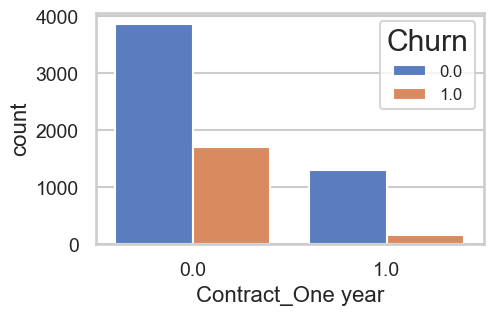

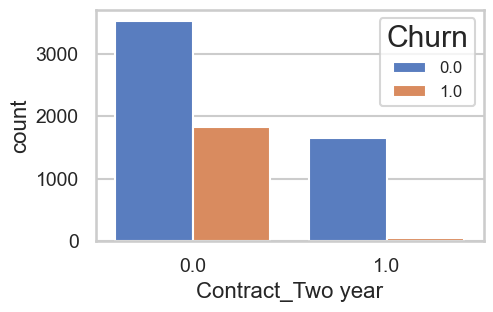

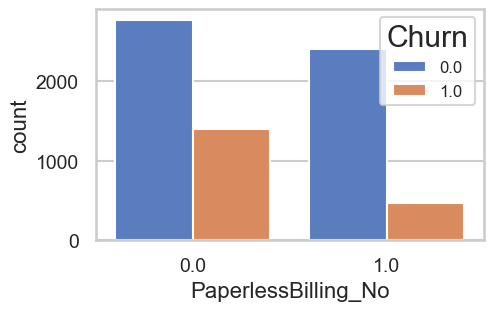

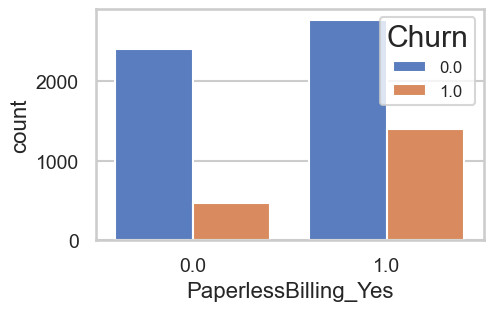

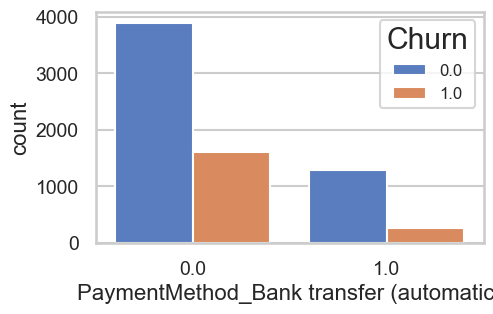

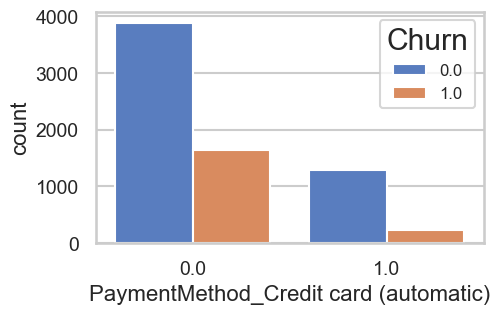

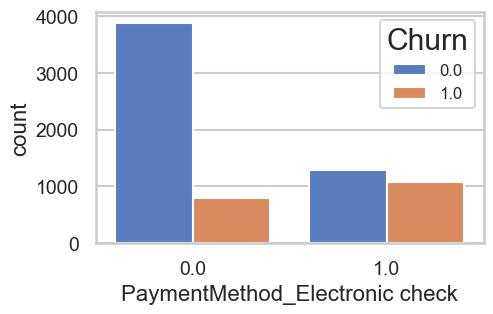

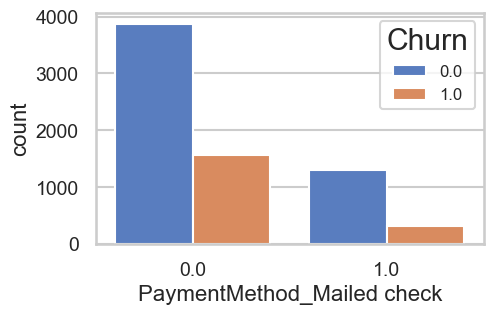

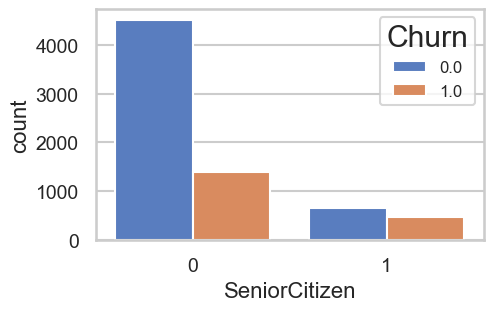

In [16]:
for i, predictor in enumerate(
    df_processed.drop(columns=["Churn", "TotalCharges", "MonthlyCharges", "tenure"])
):
    plt.figure(i, figsize=(5, 3))
    sns.countplot(data=df_processed, x=predictor, hue="Churn")

In [17]:
df_processed[["MonthlyCharges", "Churn"]]

,MonthlyCharges,Churn
0,29.85,0.0
1,56.95,0.0
2,53.85,1.0
3,42.30,0.0
4,70.70,1.0
...,...,...
7038,84.80,0.0
7039,103.20,0.0
7040,29.60,0.0
7041,74.40,1.0


#### Monthly charges and Churn

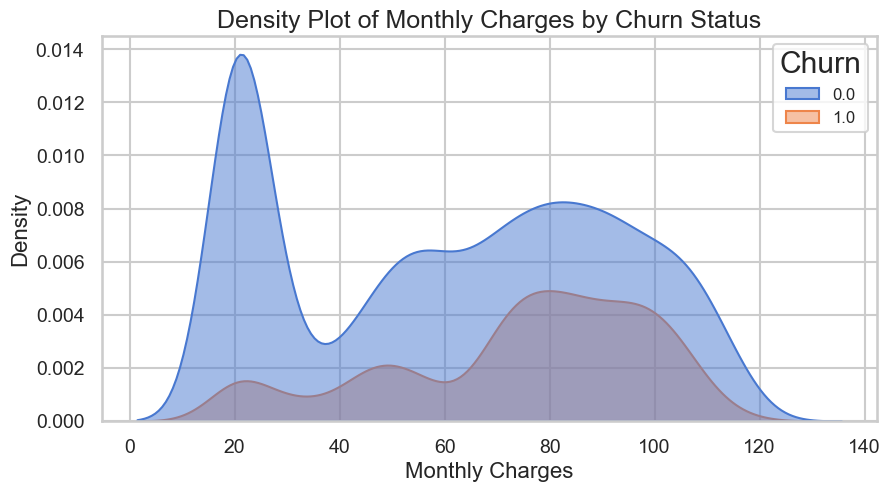

In [18]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df_processed, x="MonthlyCharges", hue="Churn", fill=True, alpha=0.5)
plt.title("Density Plot of Monthly Charges by Churn Status")
plt.xlabel("Monthly Charges")
plt.ylabel("Density")
plt.show()

Customers with lower monthly charge are more likely to churn.

#### Correlation

<Axes: >

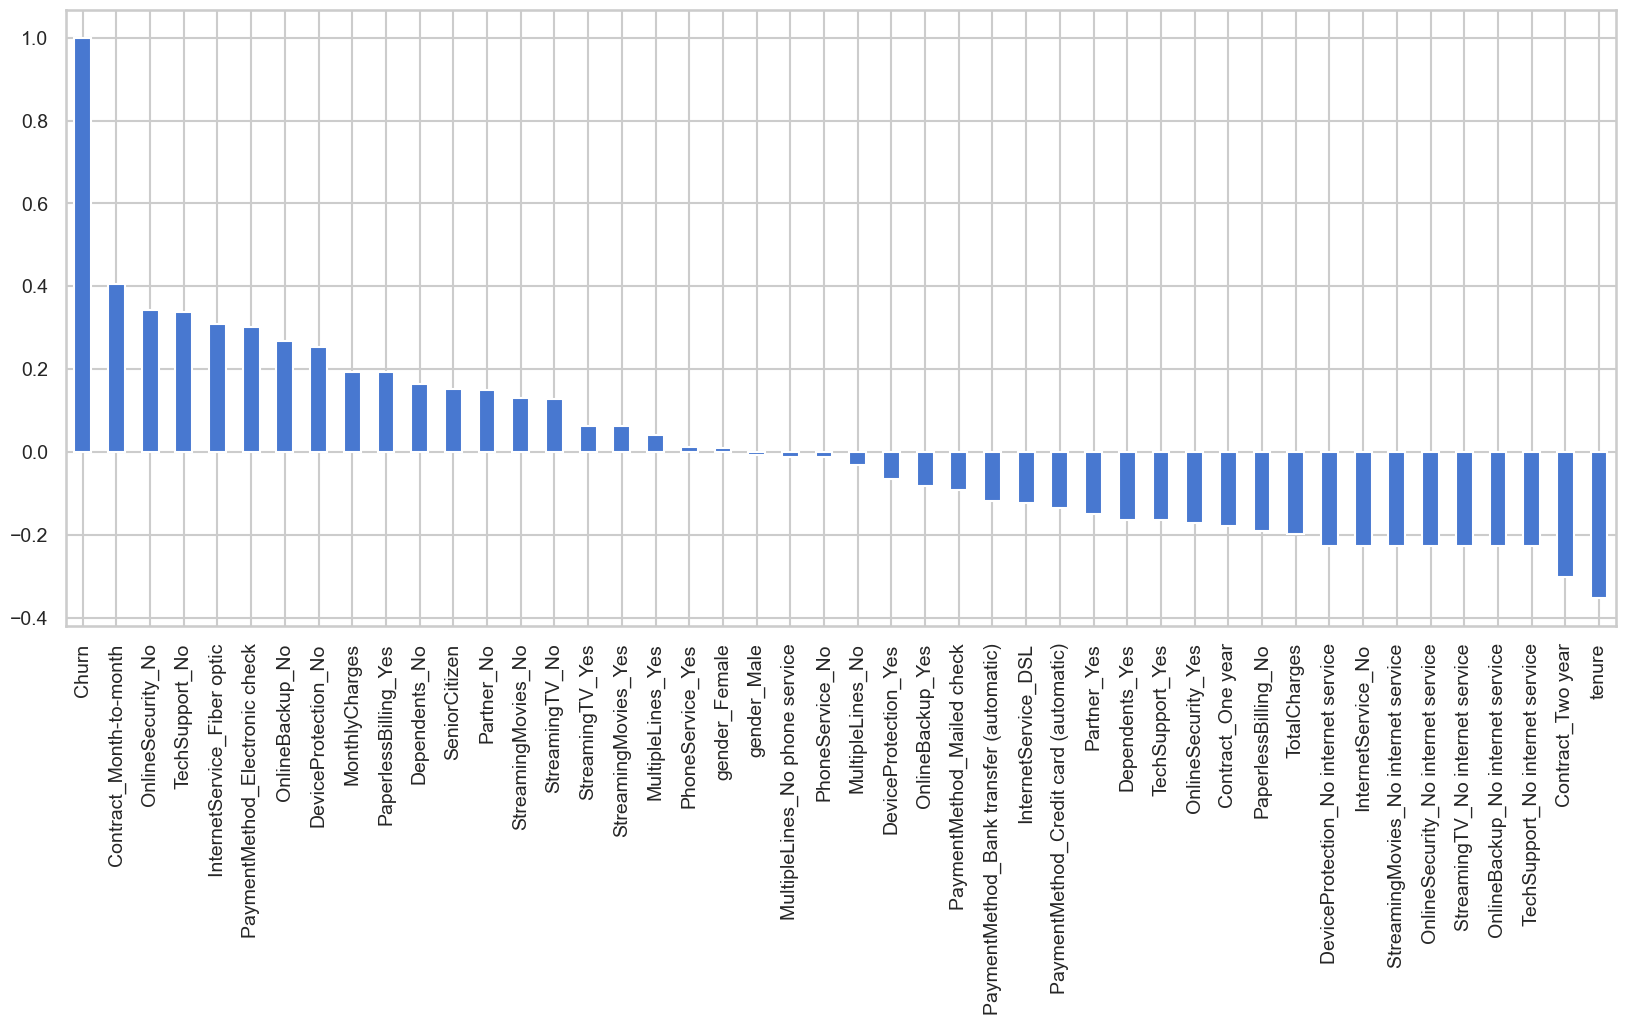

In [19]:
plt.figure(figsize=(20, 8))
df_processed.corr()["Churn"].sort_values(ascending=False).plot(kind="bar")

Get same results when doing univarite analysis.

### Conclusion

Below are categories more likely to churn:

Senior citizen; InternetService_Fiber optic; OnlineSecurty_No; OnlineBack_NO; DeviceProtection_NO; TechSupport_No; Contract_Month-to-month; PaymentMethod_Electronic check;

Customers with lower monthly charge are more likely to churn.

In [20]:
df_processed.to_pickle("../data/df_processed.pkl")

### Model Training

In [21]:
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [22]:
df = pd.read_pickle("../data/df_processed.pkl")
df.head()

,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,...,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0,1,29.85,29.85
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,34,56.95,1889.50
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0,2,53.85,108.15
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,45,42.30,1840.75
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0,2,70.70,151.65


In [23]:
# Creat train and test spilt
X = df.drop("Churn", axis=1)
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Logistic Regression

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1025
           1       0.65      0.55      0.60       384

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



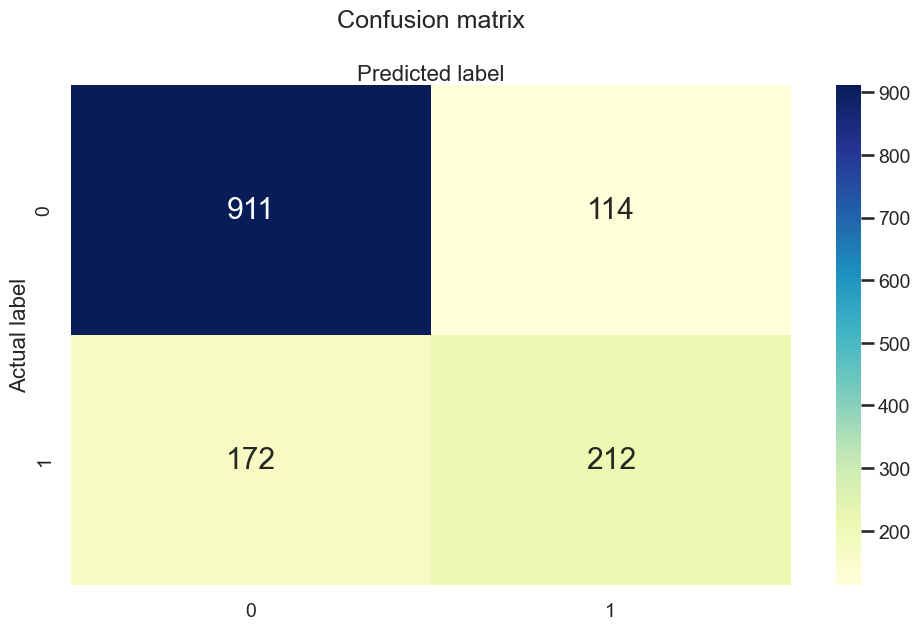

In [24]:
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

class_names = [0, 1]  # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
print(classification_report(y_test, y_pred, labels=[0, 1]))

As we can see that the accuracy is quite low, and as it's an imbalanced dataset, we shouldn't consider Accuracy as our metrics to measure the model, as Accuracy is cursed in imbalanced datasets.

Hence, we need to check recall, precision & f1 score for the minority class, and it's quite evident that the precision, recall & f1 score is too low for Class 1, i.e. churned customers.



### Decision Tree

In [25]:
model_dt = DecisionTreeClassifier(
    criterion="gini", random_state=100, max_depth=6, min_samples_leaf=8
)
model_dt.fit(X_train, y_train)
y_pred = model_dt.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1025
           1       0.60      0.54      0.57       384

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.77      1409



#### Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    random_state=100,
    max_depth=6,
    min_samples_leaf=8,
)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1025
           1       0.66      0.50      0.57       384

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.79      0.78      1409



#### XGBoost

In [27]:
from xgboost import XGBClassifier

model_xg = XGBClassifier()
model_xg.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1025
           1       0.66      0.50      0.57       384

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.79      0.78      1409



#### Hyperparameter tuning

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# Define the model
model_xg = XGBClassifier()

param_distributions = {
    "max_depth": randint(3, 6),
    "learning_rate": uniform(0.01, 0.2),
    "n_estimators": randint(100, 300),
    "subsample": uniform(0.8, 0.2),
}

random_search = RandomizedSearchCV(
    estimator=model_xg,
    param_distributions=param_distributions,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learning_rate=0.0849080237694725, max_depth=3, n_estimators=114, subsample=0.9463987883622811; total time=   0.6s
[CV] END learning_rate=0.021616722433639893, max_depth=3, n_estimators=199, subsample=0.8285733635843882; total time=   1.0s
[CV] END learning_rate=0.021616722433639893, max_depth=3, n_estimators=199, subsample=0.8285733635843882; total time=   1.0s
[CV] END learning_rate=0.14017769458977059, max_depth=3, n_estimators=101, subsample=0.944399754453365; total time=   0.5s
[CV] END learning_rate=0.13349630192554332, max_depth=4, n_estimators=121, subsample=0.8014132610439435; total time=   0.9s
[CV] END learning_rate=0.13349630192554332, max_depth=4, n_estimators=121, subsample=0.8014132610439435; total time=   0.8s
[CV] END learning_rate=0.014612485008283152, max_depth=5, n_estimators=158, subsample=0.8799721943430512; total time=   2.1s
[CV] END learning_rate=0.13367720186661747, max_depth=5, n_estimator

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7eaca0142620>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eaca1bfff10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eaca01434c0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7eaca0141a50>},
                   random_state=42, verbose=2)

In [50]:
print(random_search.best_params_)

{'learning_rate': 0.11052741862103842, 'max_depth': 5, 'n_estimators': 291, 'subsample': 0.9728335130143807}


In [ ]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0, 1]))

#### Compare models

In [28]:
from pycaret.classification import setup, compare_models

clf1 = setup(
    df,
    target="Churn",
    session_id=123,
    log_experiment=True,
    experiment_name="Churn telecom",
)

,Description,Value
0,Session id,123
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(7043, 46)"
4,Transformed data shape,"(7043, 46)"
5,Transformed train set shape,"(4930, 46)"
6,Transformed test set shape,"(2113, 46)"
7,Numeric features,45
8,Preprocess,True
9,Imputation type,simple


In [29]:
best_model = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:51:06
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8026,0.8452,0.5505,0.6538,0.5972,0.4678,0.4712,1.2450
gbc,Gradient Boosting Classifier,0.8022,0.8482,0.5291,0.6605,0.5862,0.4585,0.4643,0.1130
ada,Ada Boost Classifier,0.8004,0.8473,0.5314,0.6525,0.5847,0.4554,0.4602,0.0530
ridge,Ridge Classifier,0.7994,0.0000,0.5199,0.6553,0.5790,0.4497,0.4554,0.0120
lda,Linear Discriminant Analysis,0.7966,0.8373,0.5543,0.6349,0.5913,0.4568,0.4590,0.0120
catboost,CatBoost Classifier,0.7963,0.8404,0.5199,0.6452,0.5745,0.4430,0.4482,1.3860
lightgbm,Light Gradient Boosting Machine,0.7917,0.8331,0.5322,0.6273,0.5747,0.4382,0.4415,0.2690
xgboost,Extreme Gradient Boosting,0.7895,0.8239,0.5330,0.6207,0.5723,0.4340,0.4370,0.0490
rf,Random Forest Classifier,0.7868,0.8218,0.4848,0.6292,0.5464,0.4103,0.4170,0.0750
svm,SVM - Linear Kernel,0.7769,0.0000,0.4213,0.6389,0.4846,0.3560,0.3800,0.0170


#### Ensemble model

In [30]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

xgb = XGBClassifier()
lr = LogisticRegression()
gbc = GradientBoostingClassifier()
models = {"xgb": xgb, "lr": lr, "gbc": gbc}

## Train the models
for name_model, model in models.items():
    print(f"Model: {name_model}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, labels=[0, 1]))

votation_classifier = VotingClassifier(
    estimators=[("lr", models["xgb"]), ("xgb", models["lr"]), ("gbc", models["gbc"])],
    voting="soft",
)
print("Model: VotationClassifier")
votation_classifier.fit(X_train, y_train)
y_pred = votation_classifier.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0, 1]))

Model: xgb
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1025
           1       0.61      0.55      0.58       384

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.77      0.78      0.78      1409

Model: lr
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1025
           1       0.65      0.54      0.59       384

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

Model: gbc
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1025
           1       0.66      0.54      0.59       384

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.7

In [31]:
joblib.dump(votation_classifier, "../models/votation_classifier.pkl")

['../models/votation_classifier.pkl']